In [24]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


snippet for duration reporting

In [ ]:
timestamp_start = datetime.datetime.now()

timestamp_dur = datetime.datetime.now() - timestamp_start
print('Elapsed time = ' + str(timestamp_dur))

# [ IMPORTS ]

In [25]:
import datetime
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import statistics as stats
import scipy.signal as scsig

import tensorflow as tf
import keras
from tensorflow.keras.layers import Dense, Input, LSTM, Conv1D, MaxPooling1D, Flatten, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import to_categorical

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

# [ GLOBAL ]

In [26]:
# Resample every signal to this rate for consistency
BASIC_SRATE = 128 #Hz
print('Basic sampling rate(Hz): '+str(BASIC_SRATE))


#=================================================
# working directories
#=================================================

# > _ base working directory
global_dir = '/content/drive/My Drive/Masters/workdir/ecg_data'
print('GLOBAL DIR :: '+global_dir)

# >> global MAT directory, contains signal data in matlab (.mat) format
global_matdir = os.path.join(global_dir, 'db_mat') 
print('GLOBAL MAT DIR :: '+global_matdir)

# >> global NPY directory, contains signal and meta data in numpy (.npy) format
global_npydir = os.path.join(global_dir, 'db_npy') 
print('GLOBAL NPY DIR :: '+global_npydir)

# >> global datasets directory, contains manually generated datasets
global_dsdir = os.path.join(global_dir, 'db_dataset') 
print('GLOBAL DATSET DIR :: '+global_dsdir)

# >> model directory, contains model weights and test results use load_weights(), save_weights() 
global_modeldir = os.path.join(global_dir, 'db_model')
print('GLOBAL MODEL DIR :: ' + global_modeldir)

#>>----------------------------------------------- 


#=================================================
# Annotations
#=================================================
# >> annotation directory, contains annotation mapping files to be used for experiments
global_antdir = os.path.join(global_dir, 'db_ant') 
print('GLOBAL ANNOTATION DIR :: ' + global_antdir)
#>>----------------------------------------------- 


#=================================================
# File Identifiers
#=================================================
# beat and non-beat annotations, signal data types to be used to save data in npy format
g_BA = 'BA'                     #<<--- beat annotations (@orignal Sampling rate)
g_NBA = 'NBA'                   #<<--- non-beat annotations (@orignal Sampling rate)
g_RAW2 = 'RAW2'                 #<<--- Raw lead2 signal from mat file
g_BLF2 = 'BLF2'                 #<<--- Baseline fitted signal
g_RES2 = 'RES2'                 #<<--- Resampled to BASIC_SRATE

g_SIG2 = 'SIG2'     #<<--- Removed manual gain
g_RPEAK = 'RRP'     #<<--- Resampled R-peaks
#>>----------------------------------------------- 

Basic sampling rate(Hz): 128
GLOBAL DIR :: /content/drive/My Drive/Masters/workdir/ecg_data
GLOBAL MAT DIR :: /content/drive/My Drive/Masters/workdir/ecg_data/db_mat
GLOBAL NPY DIR :: /content/drive/My Drive/Masters/workdir/ecg_data/db_npy
GLOBAL DATSET DIR :: /content/drive/My Drive/Masters/workdir/ecg_data/db_dataset
GLOBAL MODEL DIR :: /content/drive/My Drive/Masters/workdir/ecg_data/db_model
GLOBAL ANNOTATION DIR :: /content/drive/My Drive/Masters/workdir/ecg_data/db_ant


# [ CLASS DEFINITIONS ]

In [27]:
#---------------------------------------------------------------------------------------------------------------------------------------------
# CLASS ecg_db : represents one ECG database
#---------------------------------------------------------------------------------------------------------------------------------------------
class ecg_db:
    def __init__(self, dbname,  tag_recs):
        print('\nInitailze new ecg database ... ')
        self.name = dbname  #str
        self.dir_npy = os.path.join(global_npydir , dbname+'_npy') #str
        self.recs = set(np.loadtxt(os.path.join(self.dir_npy,'RECORDS'), dtype='str',delimiter="\n")) #set
        self.recs_tag = set(tag_recs)
        self.recs_dict = {} # initially empty, will be loaded on demand using function 'get_record'
        self.info()

    def info(self):
        print( 'DB NAME :: '+ self.name)
        print( 'DATA DIR :: ' + self.dir_npy )
        print( 'RECORDS :: [' +str(len(self.recs))+'] ' + str(self.recs) )
        print( 'TAG RECORDS :: [' +str(len(self.recs_tag))+'] ' + str(self.recs_tag))
        return 0

    def get_record(self,rec):
        if not (rec in self.recs_dict.keys()):
            self.recs_dict[rec] = ecg_record(self,rec)
        return self.recs_dict[rec]
    
    def get_random_record(self, recset):
        rec = random.choice(list(recset))
        if not (rec in self.recs_dict.keys()):
            self.recs_dict[rec] = ecg_record(self,rec)
        return self.recs_dict[rec]

#---------------------------------------------------------------------------------------------------------------------------------------------

#---------------------------------------------------------------------------------------------------------------------------------------------
# CLASS ecg_record : represents one ECG Record in any database
#---------------------------------------------------------------------------------------------------------------------------------------------
g_SUPRESS_DATA_WARNING=False
class ecg_record:

    def __init__(self, db, recname):
        self.db = db                                # class:{ecg_db}    object this record belongs to
        self.rec = recname                          # string            name of this record
        self.name = db.name + '_'+ recname          # string            full name including db.name
        if not recname in db.recs:
            print('WARNING:: Record "'+ recname +'" not found in database '+ db.name )
        self.data_npy = {}                          # dict dict of data file content used in self.read_data_npy('key')
        self.data_temp = {}                          # dict dict of data file content used in self.read_data_temp('key')
        self.binfo = None                           # class binfo       

##<------------------------------------------------- get instance of binfo class
    def read_binfo(self):
        if self.binfo == None:
            self.binfo = ecg_binfo(self)
        return self.binfo

    def refresh_binfo(self):
        self.binfo = ecg_binfo(self)
        return self.binfo

##<------------------------------------------------- data reading for npydir
    def load_data(self, data_type):
        ipath = os.path.join(self.db.dir_npy, self.rec + '_'+data_type+'.npy')
        try: # try to load this data
            self.data_npy[data_type] = np.load(ipath) # adds this to dictionary so next time it can read
            return self.data_npy[data_type] #= np.load(self.dirs[s])
        except:
            if g_SUPRESS_DATA_WARNING == False:
                print('WARNING:: Cant load "'+data_type+ '" file at '+ str(ipath) )
            return np.array([])
        
    def read_data(self, data_type):
        if data_type in self.data_npy.keys():
            return self.data_npy[data_type] #= np.load(self.dirs[s])
        else:
            return self.load_data(data_type)

##<------------------------------------------------- for tempdir
    def load_data_temp(self, data_type, dir_path):
        ipath = os.path.join(dir_path, self.rec + '_'+data_type+'.npy')
        try: # try to load this data
            self.data_temp[data_type] = np.load(ipath) # adds this to dictionary so next time it can read
            return self.data_temp[data_type] #= np.load(self.dirs[s])
        except:
            if g_SUPRESS_DATA_WARNING == False:
                print('WARNING:: Cant load "'+data_type+ '" file at '+ str(ipath) )
            return np.array([])
        
    def read_data_temp(self, data_type, dir_path):
        if data_type in self.data_temp.keys():
            return self.data_temp[data_type] #= np.load(self.dirs[s])
        else:
            return self.load_data_temp(data_type, dir_path)

    def save_data_temp(self, data_type, data_array, dir_path):
        ipath = os.path.join(dir_path, self.rec + '_'+data_type+'.npy')
        np.save(ipath, data_array)
        return ipath

    def del_data_temp(self, data_type, dir_path, vb):
        ipath = os.path.join(dir_path, self.rec + '_'+data_type+'.npy')
        if os.path.exists(ipath):
            if vb:
                print('Removing: '+str(ipath))
            os.remove(ipath)
            return 1
        else:
            return 0
#------------------------------------------------------------------------------------------------

#---------------------------------------------------------------------------------------------------------------------------------------------
# CLASS ecg_binfo : information about beats in a record
#---------------------------------------------------------------------------------------------------------------------------------------------
class ecg_binfo:
    def __init__(self, rec):
         
        # the record object
        self.rec = rec
        
        # read orignal annotations
        r_peaks_ants = rec.read_data(g_RPEAK)       # resampled ant file
        
        # calculate count of R peaks (excluding first and last)
        self.rp_count = len(r_peaks_ants) - 2
        
        # Extract Location and Labels of Peaks (exclude first and last beat)
        r_peaks_int = r_peaks_ants[:,0].astype('int')
        r_ants_str = r_peaks_ants[:,1]
        
        #self.rp_first = r_peaks_int_raw[0] # = self.rp_prev[0]
        #self.rp_last = r_peaks_int_raw[-1] # = self.rp_next[-1]
        
        # Location
        self.rp_curr = r_peaks_int[1:-1]    # current R peak
        self.rp_prev = r_peaks_int[0:-2]    # previous R peak (in samples)
        self.rp_next = r_peaks_int[2:]      # next R peak (in samples)
        
        # Label
        self.rl_curr = r_ants_str[1:-1]
        self.rl_prev = r_ants_str[0:-2]
        self.rl_next = r_ants_str[2:]

        # mapped Label
        self.rli_prev = []
        self.rli_curr = []
        self.rli_next = []

        # calculate temporal info
        self.rp_sec = self.rp_curr / BASIC_SRATE                 # peak location (in sec)
        self.rri_prev = (self.rp_curr - self.rp_prev) / BASIC_SRATE   # prev RRI (in sec) 
        self.rri_next = (self.rp_next - self.rp_curr) / BASIC_SRATE   # next RRI (in sec) 
        self.rri_delta = (self.rri_next - self.rri_prev)              # difference b/w prev and next RRI (in sec) 
        self.rri_dur = (self.rri_next + self.rri_prev)                # total duration from prev to next R-peak
        

    def get_signal_data_var(self, ith_peak): # data_type = g_SIG_II_POSTFIX
        # prev peak to next peak
        sel_sig = self.rec.read_data(g_SIG2) 
        ff = self.rp_prev[ith_peak]
        tt = self.rp_next[ith_peak]
        pp = self.rp_curr[ith_peak]
        return sel_sig[ff:tt+1], (pp-ff), (tt+1-ff) #<- also return position of peak
    
    def get_signal_data_fix(self, ith_peak, v_left_sec, v_right_sec): # data_type = g_SIG_II_POSTFIX
        return self.get_signal_data_fix_samples(ith_peak,int(v_left_sec*BASIC_SRATE),int(v_right_sec*BASIC_SRATE))

    def get_signal_data_fix_samples(self, ith_peak, v_left, v_right): # data_type = g_SIG_II_POSTFIX
        sel_sig = self.rec.read_data(g_SIG2) 
        ff = self.rp_curr[ith_peak]-v_left
        tt = self.rp_curr[ith_peak]+v_right
        pp = self.rp_curr[ith_peak]

        f_pad,t_pad=0,0
        if ff<0:
            f_pad=0-ff
            ff=0

        if tt>len(sel_sig):
            tpad=tt-len(sel_sig)
            tt=len(sel_sig)

        sel_part = np.hstack((
            np.zeros(f_pad),
            sel_sig[ff:tt],
            np.zeros(t_pad),
            ))

        pl = pp+f_pad
        return sel_part, pl #<- also return position of peak

    def get_local_hrT(self,local_window_start,local_window_end): # within a time duration
        lws = local_window_start*BASIC_SRATE # in samples        
        lwe = local_window_end*BASIC_SRATE # in samples        
        #ff and tt should be within signal limits
        # if not in limits then take shortest : means truncate lw duration
        ff = max( lws ,self.rp_prev[0])
        tt = min( lwe ,self.rp_next[-1])
        dd = (tt-ff)/BASIC_SRATE
        qq = np.where((self.rp_curr>=ff) & (self.rp_curr<=tt))[0] #  these many peaks in dd sec
        nq = len(qq)# qq must be at least 2 peaks
        # if qq peaks in dd secs then heart rate = (qq/dd) bps =  (qq/dd)*60 bpm
        if nq<2:  
             dd=0
             local_bps = 0
        else:
             ff = self.rp_curr[qq[0]]
             tt = self.rp_curr[qq[-1]]
             dd = (tt-ff)/BASIC_SRATE
             local_bps = (nq-1)/dd #bps
        
        return local_bps, dd
   
     
    def get_local_hr(self,ith_peak, local_window_left,local_window_right): # within local duration of ith peak
        lwl = local_window_left*BASIC_SRATE # in samples        
        lwr = local_window_right*BASIC_SRATE # in samples        
        #ff and tt should be within signal limits
        # if not in limits then take shortest : means truncate lw duration
        ff = max(self.rp_curr[ith_peak] - lwl ,self.rp_prev[0])
        tt = min(self.rp_curr[ith_peak] + lwr ,self.rp_next[-1])
        
        qq = np.where((self.rp_curr>=ff) & (self.rp_curr<=tt))[0] #  these many peaks in dd sec
        nq = len(qq)# qq must be at least 2 peaks
        if nq<2:  
             return 0, 0
        else:
             ff = self.rp_curr[qq[0]]
             tt = self.rp_curr[qq[-1]]
             dd = (tt-ff)/BASIC_SRATE
        # if nq peaks in dd secs then heart rate = (nq/dd) bps =  (nq/dd)*60 bpm
             local_bps = (nq-1)/dd #bps
             return local_bps, dd

    def get_local_hrA(self, local_window_left,local_window_right): # within local duration of all peaks
        lwl = local_window_left*BASIC_SRATE # in samples        
        lwr = local_window_right*BASIC_SRATE # in samples       
        #ff and tt should be within signal limits
        # if not in limits then take shortest : means truncate lw duration
        local_bps = np.zeros(self.rp_count,dtype='float')
        local_dd = np.zeros(self.rp_count,dtype='float')
        for ith_peak in range(0, self.rp_count):
             ff = max(self.rp_curr[ith_peak] - lwl ,self.rp_prev[0])
             tt = min(self.rp_curr[ith_peak] + lwr ,self.rp_next[-1])
             qq = np.where((self.rp_curr>=ff) & (self.rp_curr<=tt))[0] #  these many peaks in dd sec
             nq = len(qq) # qq must be at least 2 peaks
             if nq<2:  
                  local_bps[ith_peak] = 0 #bps
                  local_dd[ith_peak] = 0 #bps
             else:
                  ff = self.rp_curr[qq[0]]
                  tt = self.rp_curr[qq[-1]]
                  dd = (tt-ff)/BASIC_SRATE
                  local_bps[ith_peak] = (nq-1)/dd #bps
                  local_dd[ith_peak] = dd #bps
        return local_bps, local_dd
    
    def map_ants2int(self,map_dict):
        if len(self.rli_curr)!=self.rp_count:
            temp = np.zeros(self.rp_count+2,dtype='str')
            temp[0] =  map_dict[self.rl_prev[0]]
            for i in range(0, self.rp_count):
                temp[i+1] = map_dict[self.rl_curr[i]]
            temp[-1] =  map_dict[self.rl_next[-1]]
            self.rli_curr = temp[1:-1]
            self.rli_prev = temp[0:-2]
            self.rli_next = temp[2:]



# [ BUILD STANDARD DBs ]

In [28]:
print('Buidling standard databases')
#------------------------------------------------------------------------
std_mitdb = ecg_db('mitdb', [])
#------------------------------------------------------------------------
std_svdb = ecg_db('svdb', [])
#------------------------------------------------------------------------
std_incartdb= ecg_db('incartdb', [])
#------------------------------------------------------------------------

Buidling standard databases

Initailze new ecg database ... 
DB NAME :: mitdb
DATA DIR :: /content/drive/My Drive/Masters/workdir/ecg_data/db_npy/mitdb_npy
RECORDS :: [48] {'104', '119', '123', '109', '201', '210', '116', '213', '111', '209', '105', '122', '203', '230', '220', '221', '107', '117', '100', '214', '208', '233', '115', '202', '205', '212', '124', '200', '231', '103', '228', '215', '223', '234', '112', '106', '232', '113', '114', '121', '118', '217', '222', '108', '207', '101', '219', '102'}
TAG RECORDS :: [0] set()

Initailze new ecg database ... 
DB NAME :: svdb
DATA DIR :: /content/drive/My Drive/Masters/workdir/ecg_data/db_npy/svdb_npy
RECORDS :: [78] {'823', '858', '849', '867', '884', '865', '852', '828', '800', '871', '878', '888', '861', '862', '810', '802', '894', '846', '854', '856', '881', '882', '807', '887', '855', '851', '805', '803', '876', '883', '870', '809', '879', '874', '890', '868', '820', '847', '811', '827', '848', '885', '886', '822', '850', '877', '

# [ PERFORMANCE MEASURES ]

In [29]:
#=========================================================================================================================
#======================= NEURAL NETWORK PERFORMANCE MEASURES
#=========================================================================================================================
# 3.3 :: define performance evaluation functions

def get_performance(conf_matrix):
    #how many classes? = len of conf_matril
    nos_class = len(conf_matrix[0,:]) # len of 0th row
    res = np.zeros((0,8),dtype ='float64')
    for i in range(0,nos_class):
        # for each class calculate 4 performance measure - ACC, PRE, SEN, SPF, 
        # first compute TP, TN, FP, FN
        TP = conf_matrix[i,i]
        FP = np.sum(conf_matrix[:,i]) - TP
        FN = np.sum(conf_matrix[i,:]) - TP
        TN = np.sum(conf_matrix) - FN - FP - TP

        ACC = (TP+TN)   /   (TP+FP+FN+TN)
        PRE = (TP)      /   (TP+FP)
        SEN = (TP)      /   (TP+FN)
        SPF = (TN)      /   (TN+FP)

        res_i = np.array([TP, FN, FP, TN, ACC, PRE, SEN, SPF])
        res = np.vstack((res,res_i))
    return res


#------------------------------------------------------------------PRINTING

def print_lstr(class_labels):
    g_LSTR=''   # HEADER ROW for printing confusing matrix
    for i in range(0,len(class_labels)):
        g_LSTR+='\t'+str(class_labels[i])
    return  g_LSTR

def print_cf_row(cf_row,nos_labels):
    res = ''
    for j in range(0,nos_labels):
        res += '\t'+ str(cf_row[j])
    return res
def print_conf_matrix(conf_matrix, suffix, class_labels):
    res=(suffix+'A\\P' + print_lstr(class_labels)+'\n')
    nos_l=len(class_labels)
    for i in range(0,nos_l):
        res+=(suffix+str(class_labels[i]) + print_cf_row(conf_matrix[i],nos_l )+'\n')
    return res
def print_performance(perf_measures, class_labels):
    nos_class = len(perf_measures[:,0])
    print('Performance for '+str(nos_class)+' classes')
    print ('Class\tACC\tPRE\tSEN\tSPF')
    for i in range(0, nos_class):
        perf_i = np.round(perf_measures [i,:],2)
        #print('\tT.P : '+str(perf_i[0])+'\tF.N : '+str(perf_i[1]))
        #print('\tF.P : '+str(perf_i[2])+'\tT.N : '+str(perf_i[3]))
        print(str(class_labels[i])+'\t'+str(perf_i[4])+'\t'+str(perf_i[5])+'\t'+str(perf_i[6])+'\t'+str(perf_i[7]))
    return
#------------------------------------------------------------------

def plot_ecg_segment(signal_info, signal_array, fsec, tsec, x_scale, y_scale, y_low, y_high, mticks_pos, show_rris, predx, predy, a_color, gain=1):
    # plot signal segments
    #<<---------------------------------------------Select ECG Segment
    dsec = tsec - fsec
    print(signal_info.rec.name)
    if len(signal_array)==0:
        print('WARNING::Signal was not loaded.')
        return 0
    else:
        ff = int(fsec * BASIC_SRATE)
        tt = int(tsec * BASIC_SRATE)
        dd = tt - ff

        bps = signal_array[ff:tt] * gain  # signal data * gain

        lim_query = np.where((signal_info.rp_sec >= fsec) & (signal_info.rp_sec < tsec))[0]

        dticks = signal_info.rp_curr[lim_query]-ff  # tick position
        nos_ticks = len(dticks)

        dlabels = signal_info.rl_curr[lim_query]    # orignal labels
        dilabels = signal_info.rli_curr[lim_query]  # mapped labels
        ditruth = predy[lim_query]
        dpredx = predx[lim_query]
        diPred = dpredx.argmax(axis=1)
        diPredCol = np.zeros(nos_ticks, dtype='U15') 
        for i in range(0,nos_ticks):
            if diPred[i]==0:
                diPredCol[i]= 'tab:green'      
            else:
                diPredCol[i]= a_color  
        dicolors = np.zeros(nos_ticks, dtype='U15') # get color repesentation
        for i in range(0,nos_ticks):
            dicolors[i]= g_STD_LABELS[dilabels[i]]

        print('Time Interval{'+str(dsec)+'s}:['+str(fsec)+':'+str(tsec)+']')
        if nos_ticks > 0:
            print('Beat Interval{'+str(nos_ticks)+'#}:['+str(lim_query[0])+':'+str(lim_query[-1])+']')
        else:
            print('Beat Interval{'+str(nos_ticks)+'#}')

        # prepare figure: predictions
        plt.figure('ecg predictions', figsize = (dsec*x_scale ,(y_high-y_low) * y_scale) )
        plt.xlim(0, len(bps))
        plt.ylim(-0.5,1.1)
        plt.yticks([])
        plt.xticks(dticks,dlabels)
        plt.grid(axis='x')
        plt.hlines(0,0,len(bps), linewidth=0.3)
        plt.hlines(0.5,0,len(bps), linewidth=0.3)
        plt.hlines(1,0,len(bps), linewidth=0.3)
        plt.scatter(dticks,np.zeros(nos_ticks)-0.40,marker='s',color=dicolors)
        plt.scatter(dticks,np.zeros(nos_ticks)-0.20,marker='o',color=diPredCol)

        pred_str = np.zeros(len(diPred))
        for i in range(0,len(diPred)):
            pred_str[i]=dpredx[i][diPred[i]]
            
        plt.scatter(dticks,pred_str,marker='.',color='black')

        # where predy is 0 and predx is 1
        d_aN_pA = dticks[np.where((ditruth==0)&(diPred==1))[0]]
        plt.scatter(d_aN_pA,np.zeros(len(d_aN_pA)),marker='x',color='tab:green')

        d_aA_pN = dticks[np.where((ditruth==1)&(diPred==0))[0]]
        plt.scatter(d_aA_pN,np.zeros(len(d_aA_pN)),marker='x',color='tab:red')

        #plt.scatter(dticks,dpredx[:,0],marker='x',color='tab:green')
        #plt.scatter(dticks,dpredx[:,1],marker='x',color=a_color)

        plt.tight_layout()
        plt.show()
        

        # prepare figure: signal
        plt.figure('ecg signal', figsize = (dsec*x_scale ,(y_high-y_low) * y_scale) )
        plt.xlim(0, len(bps))
        plt.ylim(y_low,y_high)
        plt.yticks([])
        plt.xticks(dticks,dlabels)
        #x_grid = np.arange(0,tt-ff, 1*BASIC_SRATE)
        #plt.xticks(x_grid)
        plt.grid(axis='x')
        # plot signal and baseline
        plt.plot(bps, linewidth=0.5, color='black')
        plt.hlines(0,0,len(bps), linewidth=0.3)
        # plot mapped labels
        plt.scatter(dticks,np.zeros(nos_ticks)+mticks_pos,marker='s',color=dicolors)

        # finalize
        plt.tight_layout()
        plt.show()
        
        if show_rris:
             ddur = signal_info.rri_dur[lim_query]       # duration
             ddel = np.absolute(signal_info.rri_delta[lim_query] )      # delta rri
             # prepare figure: rri,delta rri
             my_low, my_high = -0.1, 3.5
             plt.figure('ecg meta', figsize = (dsec*x_scale ,(my_high-my_low) * 1.5*y_scale) )
             plt.xlim(0, len(bps))
             plt.ylim(my_low,my_high)
             plt.yticks([])
             plt.xticks(dticks,dlabels)
             #x_grid = np.arange(0,tt-ff, 1*BASIC_SRATE)
             #plt.xticks(x_grid)
             plt.grid(axis='x')
     
             # plot grid and baseline
             plt.hlines(0,0,len(bps), linewidth=0.3,color='red')
             #for j in [0.5,1,1.5,2,2.5,3]:
             #    plt.hlines(j,0,len(bps), linewidth=0.3,color='black')
     
             # plot mapped labels
             plt.scatter(dticks,ddur,marker='s',color=dicolors)
             plt.scatter(dticks,ddel,marker='o',color='tab:purple')
             plt.plot(dticks,ddur,color='black',linewidth=0.5,linestyle='dotted')
             plt.plot(dticks,ddel,color='black',linewidth=0.5,linestyle='dotted')
             # finalize
             plt.tight_layout()
             plt.show()

        return bps,dticks,dlabels





---

END OF SHARED SECTION

---



# [ EXP DATA DICT ]

In [30]:
mitdb_ex = set([
            '102','104','107','217', # paced
            '207',   # VFlutter
            '212', '231',   # both N and BBB
            '108', # bad signal
            '202','203' # bad labeling
            ])
svdb_ex = set([])
incartdb_ex = set([])

#<<--------------------------------------------
std_mitdb.recs_tag = set.difference(std_mitdb.recs, mitdb_ex)
std_svdb.recs_tag = set.difference(std_svdb.recs, svdb_ex)
std_incartdb.recs_tag = set.difference(std_incartdb.recs, incartdb_ex)

#<<--------------------------------------------
std_db_msi = {}
std_db_msi['mitdb']=std_mitdb
std_db_msi['svdb']=std_svdb
std_db_msi['incartdb']=std_incartdb

#<<--------------------------------------------
std_db_ms = {}
std_db_ms['mitdb']=std_mitdb
std_db_ms['svdb']=std_svdb

#<<--------------------------------------------
std_db_mi = {}
std_db_mi['mitdb']=std_mitdb
std_db_mi['incartdb']=std_incartdb

#<<--------------------------------------------
std_db_si = {}
std_db_si['svdb']=std_svdb
std_db_si['incartdb']=std_incartdb

#<<--------------------------------------------
std_db_m = {}
std_db_m['mitdb']=std_mitdb

#<<--------------------------------------------
std_db_s = {}
std_db_s['svdb']=std_svdb

#<<--------------------------------------------
std_db_i = {}
std_db_i['incartdb']=std_incartdb



# [ --- EXP_1 : fixed --- ]

This experiment classifies beats into Normal or Abnormal category. Annotations used are N,S,V (F beats are included in V type) using CNN and fixed length beats

# [ VIEW ANNOTATION MAPPERS ]

In [31]:
ls_ants = os.listdir(global_antdir)
ls_ants=np.sort(ls_ants)
print('Available annotation files ['+str(len(ls_ants))+']')
for ls_ant in ls_ants:
    print(ls_ant)
print('--------------------------')

Available annotation files [6]
default_labels.txt
default_map.txt
nsv_labels.txt
nsv_map.txt
nsvf_labels.txt
nsvf_map.txt
--------------------------


# [ MAP ANNOTATIONS ]

In [32]:
# standard labels and mappings default_labels
sel_labels = os.path.join(global_antdir, 'nsv_labels.txt') 
sel_map = os.path.join(global_antdir, 'nsv_map.txt') 

# ----------------------------------------------------------------------
# ------ load standard labels ------------------------------------------
# ----------------------------------------------------------------------
sel_labels_data = np.loadtxt(sel_labels, dtype='str',delimiter="\t")
g_STD_LABELS={}
print('\nStandard Labels::')
for a in sel_labels_data:
    # a[0] =  # standard label (char)
    # a[1] =  # mapped color (str)
    # a[2]  = # description (str)
    g_STD_LABELS[a[0]]= a[1]
    print(a[0]+'\t'+a[1]+'\t'+a[2])

# ----------------------------------------------------------------------
# ------ load mapping data ---------------------------------------------
# ----------------------------------------------------------------------
ant_map_data = np.loadtxt(sel_map, dtype='str',delimiter="\t")
g_STD_NO_MAP = '_'
g_STD_LABELS[g_STD_NO_MAP]='black'
g_STD_MAP={}
print('\nMapping::')
for a in ant_map_data:
    # a[0] =  # orignal pysionet label (char)
    # a[1] =  # mapped standard label (char)
    # a[2]  = # description (str)
    g_STD_MAP[a[0]]= a[1] ##<<----------------mapping dictionary
    print(a[0]+'\t'+a[1]+'\t'+a[2])
print('\n',g_STD_MAP.keys())


#<<--------------------------------------------
for idb in std_db_msi.keys():
    sel_db = std_db_msi[idb]
    for irec in sel_db.recs_tag:
        sel_rec = sel_db.get_record(irec)
        sel_info = sel_rec.read_binfo()
        sel_info.map_ants2int(g_STD_MAP)



Standard Labels::
N	green	Normal
S	red	Supraventricular Premature
V	blue	Ventricular Premature

Mapping::
N	N	Normal beat
L	N	Left bundle branch block beat
R	N	Right bundle branch block beat
B	N	Bundle branch block beat (unspecified)
A	S	Atrial premature beat
a	S	Aberrated atrial premature beat
J	S	Nodal (junctional) premature beat
S	S	Supraventricular premature or ectopic beat (atrial or nodal)
V	V	Premature ventricular contraction
r	V	R-on-T premature ventricular contraction
F	V	Fusion of ventricular and normal beat
e	_	Atrial escape beat
j	_	Nodal (junctional) escape beat
n	_	Supraventricular escape beat (atrial or nodal)
E	_	Ventricular escape beat
/	_	Paced beat
f	_	Fusion of paced and normal beat
Q	_	Unclassifiable 
?	_	Beat not classified during learning
[	_	Start of ventricular flutter/fibrillation
!	_	Ventricular flutter wave
]	_	End of ventricular flutter/fibrillation
x	_	Non-conducted P-wave (blocked APC)
(	_	Waveform onset
)	_	Waveform end
p	_	Peak of P-wave
t	_	Peak of T-

# [ PARAMS ]

In [51]:
fix_left, fix_right = int(0.25*BASIC_SRATE),int(0.5*BASIC_SRATE)
vdim = fix_left+fix_right
print('Beat formation:', fix_left,fix_right)
print('Vector Dimension:', vdim)

A_Label = 'V'
g_LABELS = ['N',A_Label]
print('Abnormal label:', A_Label)
print('Class Labels:', g_LABELS)

Beat formation: 32 64
Vector Dimension: 96
Abnormal label: V
Class Labels: ['N', 'V']


# [ MODEL ]

In [52]:
cb_esr = tf.keras.callbacks.EarlyStopping(
        monitor='accuracy', 
        min_delta=0.00001, 
        patience=2, 
        verbose=0, 
        mode='auto', 
        baseline=None, 
        restore_best_weights=False)
cb_listr=[cb_esr] 
cost = 'sparse_categorical_crossentropy'
opt = 'rmsprop'
def get_modelCNN(print_summary, vdims):
    #itempo = Input( shape=(7,), name = "input_tempo" )
# NORM INPUT SIDE ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

    inorm = Input( shape=(vdims,1), name = "input_norm" )

    conv_inorm_1 =  Conv1D(30,                #filters, 
                          7,                  #kernel_size, 
                          strides=1, 
                          padding='valid', 
                          data_format='channels_last', 
                          dilation_rate=1, 
                          activation=tf.nn.leaky_relu, 
                          use_bias=True, 
                          kernel_initializer='glorot_uniform', 
                          bias_initializer='zeros', 
                          kernel_regularizer=None, 
                          bias_regularizer=None, 
                          activity_regularizer=None, 
                          kernel_constraint=None, 
                          bias_constraint=None,
                          name='conv_inorm_1') (inorm) 
    
    #maxpool_icompar_2 = MaxPooling1D(pool_size=2, 
    #                              strides=None, 
    #                              padding='valid', 
    #                              data_format='channels_last') (conv_icompar_1)
    
    conv_inorm_3 =  Conv1D(20,                #filters, 
                          3,                  #kernel_size, 
                          strides=1, 
                          padding='valid', 
                          data_format='channels_last', 
                          dilation_rate=1, 
                          activation=tf.nn.leaky_relu, 
                          use_bias=True, 
                          kernel_initializer='glorot_uniform', 
                          bias_initializer='zeros', 
                          kernel_regularizer=None, 
                          bias_regularizer=None, 
                          activity_regularizer=None, 
                          kernel_constraint=None, 
                          bias_constraint=None,
                          name='conv_inorm_3')(conv_inorm_1) #(maxpool_icompar_2)
    
    #maxpool_icompar_4 = MaxPooling1D(pool_size=2, 
    #                              strides=None, 
    #                              padding='valid', 
    #                              data_format='channels_last') (conv_icompar_3)
    conv_inorm_5 =  Conv1D(10,                #filters, 
                          3,                  #kernel_size, 
                          strides=1, 
                          padding='valid', 
                          data_format='channels_last', 
                          dilation_rate=1, 
                          activation=tf.nn.leaky_relu, 
                          use_bias=True, 
                          kernel_initializer='glorot_uniform', 
                          bias_initializer='zeros', 
                          kernel_regularizer=None, 
                          bias_regularizer=None, 
                          activity_regularizer=None, 
                          kernel_constraint=None, 
                          bias_constraint=None,
                          name='conv_inorm_5') (conv_inorm_3)#(maxpool_icompar_4)
    
    #maxpool_icompar_6 = MaxPooling1D(pool_size=2, 
    #                              strides=None, 
    #                              padding='valid', 
    #                              data_format='channels_last') (conv_icompar_5)
    
    flat_inorm_7 = Flatten(data_format=None,name='flat_inorm_7') (conv_inorm_5) #(maxpool_icompar_6)
    
# COMPAR INPUT SIDE ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

    icompar = Input( shape=(vdims,1), name = "input_compar" )

    conv_icompar_1 =  Conv1D(30,                #filters, 
                          7,                  #kernel_size, 
                          strides=1, 
                          padding='valid', 
                          data_format='channels_last', 
                          dilation_rate=1, 
                          activation=tf.nn.leaky_relu, 
                          use_bias=True, 
                          kernel_initializer='glorot_uniform', 
                          bias_initializer='zeros', 
                          kernel_regularizer=None, 
                          bias_regularizer=None, 
                          activity_regularizer=None, 
                          kernel_constraint=None, 
                          bias_constraint=None,
                          name='conv_icompar_1') (icompar) 
    
    #maxpool_icompar_2 = MaxPooling1D(pool_size=2, 
    #                              strides=None, 
    #                              padding='valid', 
    #                              data_format='channels_last') (conv_icompar_1)
    
    conv_icompar_3 =  Conv1D(20,                #filters, 
                          3,                  #kernel_size, 
                          strides=1, 
                          padding='valid', 
                          data_format='channels_last', 
                          dilation_rate=1, 
                          activation=tf.nn.leaky_relu, 
                          use_bias=True, 
                          kernel_initializer='glorot_uniform', 
                          bias_initializer='zeros', 
                          kernel_regularizer=None, 
                          bias_regularizer=None, 
                          activity_regularizer=None, 
                          kernel_constraint=None, 
                          bias_constraint=None,
                          name='conv_icompar_3')(conv_icompar_1) #(maxpool_icompar_2)
    
    #maxpool_icompar_4 = MaxPooling1D(pool_size=2, 
    #                              strides=None, 
    #                              padding='valid', 
    #                              data_format='channels_last') (conv_icompar_3)
    conv_icompar_5 =  Conv1D(10,                #filters, 
                          3,                  #kernel_size, 
                          strides=1, 
                          padding='valid', 
                          data_format='channels_last', 
                          dilation_rate=1, 
                          activation=tf.nn.leaky_relu, 
                          use_bias=True, 
                          kernel_initializer='glorot_uniform', 
                          bias_initializer='zeros', 
                          kernel_regularizer=None, 
                          bias_regularizer=None, 
                          activity_regularizer=None, 
                          kernel_constraint=None, 
                          bias_constraint=None,
                          name='conv_icompar_5') (conv_icompar_3)#(maxpool_icompar_4)
    
    #maxpool_icompar_6 = MaxPooling1D(pool_size=2, 
    #                              strides=None, 
    #                              padding='valid', 
    #                              data_format='channels_last') (conv_icompar_5)
    
    flat_icompar_7 = Flatten(data_format=None,name='flat_icompar_7') (conv_icompar_5) #(maxpool_icompar_6)
    

# CONCAT LAYER SIDE ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

    den_concat =  tf.concat([flat_inorm_7, flat_icompar_7],axis=1, name = "dense_concat") # should have 40 nodes

# DENSE SIDE ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
    
    den_fc0 = Dense(20, activation=tf.nn.relu, name = "DENSE_FC0")(den_concat)
    
    den_fc1 = Dense(10, activation=tf.nn.relu, name = "DENSE_FC1")(den_fc0)

# OUTPUT SIDE ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
    den_out = Dense(2, activation=tf.nn.softmax, name = "OUTPUT_FC")(den_fc1)

# =========================================================================================
    model=Model(inputs=[inorm,icompar], outputs=den_out)
    #-------------------------------------
    #model.get_layer(name="LSTM_50").trainable=is_trainable
    #-------------------------------------
    model.compile(loss=cost, optimizer=opt, metrics=['accuracy'])
    if print_summary:
        print(model.summary())
    return model

tm = get_modelCNN(True,vdim)

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_norm (InputLayer)         [(None, 96, 1)]      0                                            
__________________________________________________________________________________________________
input_compar (InputLayer)       [(None, 96, 1)]      0                                            
__________________________________________________________________________________________________
conv_inorm_1 (Conv1D)           (None, 90, 30)       240         input_norm[0][0]                 
__________________________________________________________________________________________________
conv_icompar_1 (Conv1D)         (None, 90, 30)       240         input_compar[0][0]               
____________________________________________________________________________________________

# [ ~List models and datasets ]

In [53]:
print(global_dsdir)
ls_ants = os.listdir(global_dsdir)
ls_ants=np.sort(ls_ants)
print('Available datasets ['+str(len(ls_ants))+']')
for ls_ant in ls_ants:
    print(ls_ant)
print('--------------------------')
print(global_modeldir)
ls_ants = os.listdir(global_modeldir)
ls_ants=np.sort(ls_ants)
print('Available Models ['+str(len(ls_ants))+']')
for ls_ant in ls_ants:
    print(ls_ant)
print('--------------------------')

/content/drive/My Drive/Masters/workdir/ecg_data/db_dataset
Available datasets [1]
train_S_m_20_p_d.npy
--------------------------
/content/drive/My Drive/Masters/workdir/ecg_data/db_model
Available Models [1]
model_S_m_20_p_d.h5
--------------------------


# [ DATASET GENRATING FUNCTIONS ]

In [37]:
def repeat_array(A, max_len, shuffle):
    lenA = len(A)
    if lenA>=max_len:
        a = np.random.choice(A, size=max_len, replace=False, p=None)
    else:
        req_n = max_len - lenA
        req_m = int(req_n/lenA)
        req_r = req_n % lenA
        a = np.random.choice(A, size=req_r, replace=False, p=None)
        for i in range(0,req_m+1):
            a = np.hstack((a,A))
    for i in range(0,shuffle):
        np.random.shuffle(a)
    return a
#<<-----------------------------------------------#<<-----------------------------------------------
#<<-----------------------------------------------#<<-----------------------------------------------

def get_normal_selection_train(binfo, selc, NR_statergy, NC_statergy, shuffle):
    nnn_q = np.where(((binfo.rli_prev=='N')&(binfo.rli_curr=='N')&(binfo.rli_next=='N')))[0]
    ana_q = np.where((((binfo.rli_prev!='N')|(binfo.rli_next!='N')) & (binfo.rli_curr=='N')))[0]
    n_q= np.where(binfo.rli_curr=='N')[0]

    nnn_c = len(nnn_q)
    ana_c = len(ana_q)
    n_c = len(n_q)
    #if nnn_c + ana_c != n_c:
        #print('\nmismatch\n')
    selF = int(selc/2)
    selL = selc - selF

    rN3 = int(selc*nnn_c/n_c) 
    rNA = selc - rN3
    
    #print(nnn_c,ana_c,n_c)


    if NR_statergy == 'pure':
        nr_ind = repeat_array(nnn_q,selc,shuffle)  
    elif NR_statergy == 'semi':
        nr_ind = np.hstack((repeat_array(nnn_q,selF,shuffle),repeat_array(ana_q,selL,shuffle)))
    elif NR_statergy == 'dynamic':
        nr_ind = np.hstack((repeat_array(nnn_q,rN3,shuffle),repeat_array(ana_q,rNA,shuffle)))
    elif NR_statergy == 'random':
        nr_ind = repeat_array(n_q,selc,shuffle)
    else:
        print('Invalid NR_Statergy')
        nr_ind = np.array([0])

    if NC_statergy == 'pure':
        nc_ind = repeat_array(nnn_q,selc,shuffle)  
    elif NC_statergy == 'semi':
        nc_ind = np.hstack((repeat_array(nnn_q,selF,shuffle),repeat_array(ana_q,selL,shuffle)))
    elif NC_statergy == 'dynamic':
        nc_ind = np.hstack((repeat_array(nnn_q,rN3,shuffle),repeat_array(ana_q,rNA,shuffle)))
    elif NC_statergy == 'random':
        nc_ind = repeat_array(n_q,selc,shuffle)
    else:
        print('Invalid NC_Statergy')
        nc_ind = np.array([0])

    
    return nr_ind, nc_ind
#<<-----------------------------------------------#<<-----------------------------------------------
#<<-----------------------------------------------#<<-----------------------------------------------


def generate_dataset_train(work_db, ex_limL, ex_limU, rli_ALabel,  NR_statergy, NC_statergy, shuffle ):
    nos_records=[]
    ds_selected = np.zeros((0,5), dtype='U10') # [db,rec,nr,c]
    for idb in work_db.keys():
        #<<--------------------
        sel_db = work_db[idb]
        for irec in sel_db.recs_tag:
            #<<--------------------
            sel_rec = sel_db.get_record(irec)
            #print('\n'+sel_rec.name)
            sbi = sel_rec.read_binfo()

            # find out all Abnormal beats
            a_query = ((sbi.rli_curr==rli_ALabel))
            a_indices = np.where(a_query)[0]
            a_count = len(a_indices)
            # limit A-type beats
            sela = 0
            if a_count<ex_limL:
                sela=0
            elif a_count>ex_limU:
                sela=ex_limU
            else:
                sela=a_count
    #<<-----------------------------------------------
            if sela==0:
                #print(sel_rec.name, '_')
                continue
    #<<-----------------------------------------------
            nr_indices, nc_indices = get_normal_selection_train(sbi, sela,  NR_statergy, NC_statergy, shuffle)
            nr_count = len(nr_indices)
            nc_count = len(nc_indices)
            if nr_count!=nc_count:
                print('Error: count NR-NC mismatch for ', sel_rec.name, nr_count,nc_count)

            nos_records.append(sel_rec.name)    
            for i in range(0,sela):
                tn = np.array([idb,irec,str(nr_indices[i]),str(nc_indices[i]),'0'])
                ta = np.array([idb,irec,str(nr_indices[i]),str(a_indices[i]),'1'])
                ds_selected = np.vstack((ds_selected,tn,ta))
    return ds_selected, nos_records
#<<-----------------------------------------------#<<-----------------------------------------------
#<<-----------------------------------------------#<<-----------------------------------------------


def get_normal_selection_test(binfo, selc, NR_statergy, shuffle, TS_low, TS_high):
    nnn_q = np.where(((binfo.rli_prev=='N')&(binfo.rli_curr=='N')&(binfo.rli_next=='N')
    &(binfo.rp_sec>=TS_low)&(binfo.rp_sec<TS_high)))[0]
    ana_q = np.where((((binfo.rli_prev!='N')|(binfo.rli_next!='N')) & (binfo.rli_curr=='N')
    &(binfo.rp_sec>=TS_low)&(binfo.rp_sec<TS_high)))[0]
    n_q = np.where((binfo.rli_curr=='N')
    &(binfo.rp_sec>=TS_low)&(binfo.rp_sec<TS_high))[0]

    nnn_c = len(nnn_q)
    ana_c = len(ana_q)
    n_c = len(n_q)

    selF = int(selc/2)
    selL = selc - selF

    rN3 = int(selc*nnn_c/n_c) 
    rNA = selc - rN3

    if NR_statergy == 'pure':
        nr_ind = repeat_array(nnn_q,selc,shuffle)  
    elif NR_statergy == 'semi':
        nr_ind = np.hstack((repeat_array(nnn_q,selF,shuffle),repeat_array(ana_q,selL,shuffle)))
    elif NR_statergy == 'dynamic':
        nr_ind = np.hstack((repeat_array(nnn_q,rN3,shuffle),repeat_array(ana_q,rNA,shuffle)))
    elif NR_statergy == 'random':
        nr_ind = repeat_array(n_q,selc,shuffle)
    else:
        print('Invalid NR_Statergy')
        nr_ind = np.array([0])

    
    return nr_ind

def load_beat_segment_fix(ds_str, work_db): # string list of samples as input ('databse','record','NR','CR', 'Label')
    ds_selected = np.zeros((0,vdim*2+1),dtype='float')
    for i in range(0,len(ds_str)):
        d = ds_str[i]
        d_db = d[0]
        d_rec = d[1]
        d_NRi = int(d[2])
        d_CRi = int(d[3])
        d_L = np.array([int(d[4])])

        sel_rec = work_db[d_db].get_record(d_rec)
        sel_info = sel_rec.read_binfo()

        d_NR,_ = sel_info.get_signal_data_fix_samples(d_NRi,fix_left,fix_right)
        d_CR,_ = sel_info.get_signal_data_fix_samples(d_CRi,fix_left,fix_right)
        d_data = np.hstack((
            d_NR,
            d_CR,
            d_L
        ))
        ds_selected = np.vstack((ds_selected,d_data))
    return ds_selected



### [ generate training dataset ]

In [54]:
ds_name = 'train_YS'
ds_path = os.path.join(global_dsdir,ds_name+'.npy') 
#<<-----------------------------------------------
train_db = std_db_m # combination of mitdb, svdb and/or incartdb
ex_limL, ex_limU = 12,20 # limit to beats to be selected
use_NRstatergy = 'pure' # pure semi dynamic random
use_NCstatergy = 'dynamic' # pure semi dynamic random

#<<------------------------------------------------------------
print('Abnormal label:', A_Label)
print('Training databases:', train_db.keys())
print('Selection Limits:', ex_limL, ex_limU)
print('NR_Statergy:', use_NRstatergy)
print('NC_Statergy:', use_NCstatergy)
print('Saving:', ds_name)
#<<-----------------------------------------------

timestamp_start = datetime.datetime.now()

#<<-----------------------------------------------
ds_selected, nos_records = generate_dataset_train(train_db, ex_limL, ex_limU, A_Label, use_NRstatergy,use_NCstatergy, 1 )
#<<-----------------------------------------------

print('Selected beats:',ds_selected.shape)
print('Used records:','[',len(nos_records),']',nos_records,)
np.save(ds_path,ds_selected)
print('saved at', ds_path)

timestamp_dur = datetime.datetime.now() - timestamp_start
print('Elapsed time = ' + str(timestamp_dur))

Abnormal label: V
Training databases: dict_keys(['mitdb'])
Selection Limits: 12 20
NR_Statergy: pure
NC_Statergy: dynamic
Saving: train_V_m_20_p_d
Selected beats: (832, 5)
Used records: [ 21 ] ['mitdb_119', 'mitdb_109', 'mitdb_201', 'mitdb_210', 'mitdb_116', 'mitdb_213', 'mitdb_105', 'mitdb_221', 'mitdb_214', 'mitdb_208', 'mitdb_233', 'mitdb_205', 'mitdb_124', 'mitdb_200', 'mitdb_228', 'mitdb_215', 'mitdb_223', 'mitdb_106', 'mitdb_114', 'mitdb_118', 'mitdb_219']
saved at /content/drive/My Drive/Masters/workdir/ecg_data/db_dataset/train_V_m_20_p_d.npy
Elapsed time = 0:00:00.036728


# [ TRAINING ]

## [ load dataset ]

In [55]:
ds_list = ['train_V_m_20_p_d']

timestamp_start = datetime.datetime.now()
ds_str = np.zeros((0,5),dtype='U10')
for ds_name in ds_list:
    ds_path = os.path.join(global_dsdir,ds_name+'.npy') 
    ds_this = np.load(ds_path)
    print('loaded:',ds_this.shape, ds_path)
    ds_str=np.vstack((ds_str,ds_this))

work_db = std_db_msi
ds_selected = load_beat_segment_fix(ds_str, work_db)

dx_N = np.expand_dims(ds_selected[:,0:vdim],axis=-1)
dx_C = np.expand_dims(ds_selected[:,vdim:-1],axis=-1)
dx_L = ds_selected[:,-1]
print(dx_N.shape,dx_C.shape,dx_L.shape)

data_x = [dx_N,dx_C]
data_y = dx_L

print('')
timestamp_dur = datetime.datetime.now() - timestamp_start
print('Elapsed time = ' + str(timestamp_dur))


loaded: (832, 5) /content/drive/My Drive/Masters/workdir/ecg_data/db_dataset/train_V_m_20_p_d.npy
(832, 96, 1) (832, 96, 1) (832,)

Elapsed time = 0:00:14.075786


Sample 346 of 832
['mitdb' '214' '1783' '1374' '0']


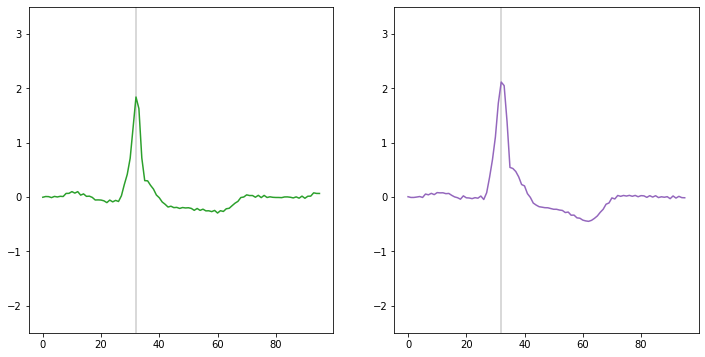

In [56]:
ds_sample = random.randint(0,len(data_y)-1)
print('Sample',ds_sample,'of',len(data_y))
print(ds_str[ds_sample])
fig,ax = plt.subplots(1,2)
fig.set_size_inches(12,6)
ax[0].set_ylim(-2.5,3.5)
ax[0].plot(dx_N[ds_sample],color='tab:green')
ax[0].vlines(fix_left,-2.5,3.5,linewidth=0.3,color='black')
ax[1].set_ylim(-2.5,3.5)
ax[1].plot(dx_C[ds_sample],color='tab:purple')
ax[1].vlines(fix_left,-2.5,3.5,linewidth=0.3,color='black')

## [ perform training ]

Training model: on ['train_V_m_20_p_d']
Epoch 1/300
26/26 [==============================] - 0s 13ms/step - loss: 0.5411 - accuracy: 0.7656
Epoch 2/300
26/26 [==============================] - 0s 13ms/step - loss: 0.2616 - accuracy: 0.9062
Epoch 3/300
26/26 [==============================] - 0s 12ms/step - loss: 0.1743 - accuracy: 0.9459
Epoch 4/300
26/26 [==============================] - 0s 13ms/step - loss: 0.1352 - accuracy: 0.9627
Epoch 5/300
26/26 [==============================] - 0s 12ms/step - loss: 0.1325 - accuracy: 0.9591
Epoch 6/300
26/26 [==============================] - 0s 12ms/step - loss: 0.0986 - accuracy: 0.9663
Epoch 7/300
26/26 [==============================] - 0s 12ms/step - loss: 0.0943 - accuracy: 0.9651
Epoch 8/300
26/26 [==============================] - 0s 12ms/step - loss: 0.0631 - accuracy: 0.9760
Epoch 9/300
26/26 [==============================] - 0s 13ms/step - loss: 0.0589 - accuracy: 0.9784
Epoch 10/300
26/26 [==============================] - 0s 13m

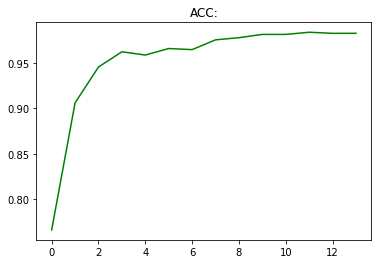

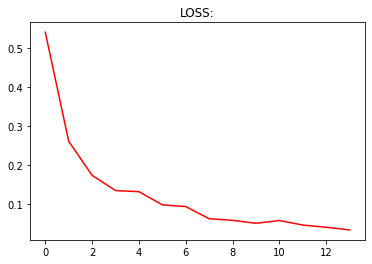

In [57]:
model=get_modelCNN(False,vdim)
# Start Training---------------------------------------------------------
timestamp_start = datetime.datetime.now()
print('Training model:', 'on',ds_list)
history = model.fit(
                    data_x, data_y,
                    #batch_size=1000,
                    epochs=300,
                    callbacks=cb_listr,
                    #validation_data=([alle_m.reshape((elen,timesteps,1)),alle_t],alle_l),
                    shuffle=True,
                    verbose=1)

timestamp_dur = datetime.datetime.now() - timestamp_start
print('Elapsed time = ' + str(timestamp_dur))
# End Training---------------------------------------------------------

plt.figure('ACC')
plt.title('ACC:')
plt.plot(history.history['accuracy'],color='green')
plt.show()

plt.figure('LOSS')
plt.title('LOSS:')
plt.plot(history.history['loss'],color='red')
plt.show()



## [ save model ]

In [58]:
ds_model = 'model_V_m_20_p_d'
# save this model
model_path = os.path.join(global_modeldir, ds_model+'.h5')
model.save_weights(model_path)
print('Saved Model Weights at : '+ str(model_path))

Saved Model Weights at : /content/drive/My Drive/Masters/workdir/ecg_data/db_model/model_V_m_20_p_d.h5


# [ TESTING ]

## [ load model ]

In [47]:
ds_model = 'model_V_m_20_p_d'       # SELECT MODEL WEIGHTS TO TEST UPON
model_path = os.path.join(global_modeldir, ds_model+'.h5')
model=get_modelCNN(False,vdim)
model.load_weights(model_path)
print('Loaded Model weights '+ str(model_path))
##<----------------------------------------------

Loaded Model weights /content/drive/My Drive/Masters/workdir/ecg_data/db_model/model_S_m_20_p_d.h5


## [ Testing - Database ]

In [ ]:
work_db = std_db_i
sel_NR_count = 4
NR_statergy = 'dynamic'
shuffle=0
TS_low, TS_high = 0*60, 5*60


cmx_global = np.zeros((len(g_LABELS),len(g_LABELS)),dtype='int32') # confusion matrix
cmx2_global = [] # prediction per record

print('Abnormal label:', A_Label)
print('Class Labels:', g_LABELS)
print('Testing database:',work_db.keys())
print('NR_Statergy:', use_NRstatergy)
print('NR_Count:', sel_NR_count)
print('NR_TimeLimits:', TS_low, TS_high)

#<<----------------------------------------
timestamp_start = datetime.datetime.now()
#<<----------------------------------------
print('\n----------------------------------------')

for idb in work_db.keys():
    #<<--------------------
    sel_db = work_db[idb]
    for irec in sel_db.recs_tag:
        #<<--------------------
        sel_rec = sel_db.get_record(irec)
        print('\n==============================================')
        #print(sel_rec.name)
        sbi = sel_rec.read_binfo()

        #<<----------------------------------------------- Select Record NR
        nr_indices = get_normal_selection_test(sbi, sel_NR_count,  NR_statergy, shuffle, TS_low, TS_high)
        nr_count = len(nr_indices)
        if nr_count!=sel_NR_count:
            print(sel_rec.name,'WARNING: count NR mismatch.... using',nr_count)        

        if nr_count==0:
            print(sel_rec.name,'ERROR: No NR beat ....skip')    
            continue

        #<<----------------------------------------------- Extract Record NR
        sig_NR = np.zeros((0,vdim),dtype='float')
        for i in range(0,nr_count):
            d_NR,_ = sbi.get_signal_data_fix_samples(nr_indices[i],fix_left,fix_right)
            sig_NR = np.vstack((sig_NR,d_NR))
        #------------------------------------------------------------ generate record data
        nrc = 0
        ds_rec = np.zeros((0,vdim*2+1))
        for i in range(0,sbi.rp_count):
            if sbi.rli_curr[i]==A_Label:
                label = 1
            else:
                label = 0
            d_CR,_ = sbi.get_signal_data_fix_samples(i,fix_left,fix_right)
            d_NR = sig_NR[nrc%nr_count]
            d_data = np.hstack((
                d_NR,d_CR,np.array([label])
            ))
            ds_rec = np.vstack((ds_rec,d_data))
            nrc+=1

        #------------------------------------------------------------ format record data
        dx_N = np.expand_dims(ds_rec[:,0:vdim],axis=-1)
        dx_C = np.expand_dims(ds_rec[:,vdim:-1],axis=-1)
        dx_L = ds_rec[:,-1]
        data_x = [dx_N,dx_C]
        data_y = dx_L

        #------------------------------------------------------------ manual prediction
        print('Record:' , sel_rec.name,dx_N.shape,dx_C.shape,dx_L.shape)
        predx = model.predict( data_x ) # - each row is a prediction of a sample
        cmx_local = np.zeros((len(g_LABELS),len(g_LABELS)),dtype='int32')
        cmx2_local = predx.argmax(axis=1)
        cmx2_global.append(cmx2_local)
        for i in range(0,len(cmx2_local)):
            alabel = int(data_y[i])
            plabel = cmx2_local[i]
            cmx_local[alabel,plabel]+=1
            cmx_global[alabel,plabel]+=1
        print('\tConfusion Matrix')
        print(print_conf_matrix( cmx_local,'', g_LABELS)) #logit('\t'+str(cmx))
        print_performance( get_performance(cmx_local) ,g_LABELS ) 
        #------------------------------------------------------------

print('\n==============================================')
print('\tGlobal Confusion Matrix')
print(print_conf_matrix( cmx_global,'', g_LABELS)) #logit('\t'+str(cmx))
print_performance( get_performance(cmx_global) ,g_LABELS ) 
#------------------------------------------------------------
print('\n==============================================')
timestamp_dur = datetime.datetime.now() - timestamp_start
print('Elapsed time = ' + str(timestamp_dur))

Abnormal label: S
Class Labels: ['N', 'S']
Testing database: dict_keys(['incartdb'])
NR_Statergy: pure
NR_Count: 4
NR_TimeLimits: 0 300

----------------------------------------

Record: incartdb_I20 (2650, 160, 1) (2650, 160, 1) (2650,)
	Confusion Matrix
A\P	N	S
N	1335	1136
S	8	171

Performance for 2 classes
Class	ACC	PRE	SEN	SPF
N	0.57	0.99	0.54	0.96
S	0.57	0.13	0.96	0.54

Record: incartdb_I50 (2996, 160, 1) (2996, 160, 1) (2996,)
	Confusion Matrix
A\P	N	S
N	1845	1151
S	0	0

Performance for 2 classes
Class	ACC	PRE	SEN	SPF
N	0.62	1.0	0.62	nan
S	0.62	0.0	nan	0.62

Record: incartdb_I48 (2355, 160, 1) (2355, 160, 1) (2355,)
	Confusion Matrix
A\P	N	S
N	2208	145
S	1	1

Performance for 2 classes
Class	ACC	PRE	SEN	SPF
N	0.94	1.0	0.94	0.5
S	0.94	0.01	0.5	0.94

Record: incartdb_I14 (1864, 160, 1) (1864, 160, 1) (1864,)
	Confusion Matrix
A\P	N	S
N	1433	431
S	0	0

Performance for 2 classes
Class	ACC	PRE	SEN	SPF
N	0.77	1.0	0.77	nan
S	0.77	0.0	nan	0.77

Record: incartdb_I70 (1664, 160, 1) (1664, 1

## [ Testing - Record ]

### [ select record ]

In [59]:
sel_db = std_incartdb
sel_rec = sel_db.get_record('I61')
ds_name = sel_rec.name
#<<-----------------------------------------------
sbi = sel_rec.read_binfo()
sbi.map_ants2int(g_STD_MAP)
sel_signal = sel_rec.read_data(g_SIG2)
print(sel_rec.name)

incartdb_I61


### [ perform testing ]

In [60]:
sel_NR_count = 10
NR_statergy = 'pure'
shuffle=0
TS_low, TS_high = 0*60, 5*60

print('Abnormal label:', A_Label)
print('Testing record:',sel_rec.name)
print('NR_Statergy:', use_NRstatergy)
print('NR_Count:', sel_NR_count)
print('NR_TimeLimits:', TS_low, TS_high)
print('Class Labels:', g_LABELS)
#<<-----------------------------------------------

timestamp_start = datetime.datetime.now()

print('\n==============================================')
#<<----------------------------------------------- Select Record NR
nr_indices = get_normal_selection_test(sbi, sel_NR_count,  NR_statergy, shuffle, TS_low, TS_high)
nr_count = len(nr_indices)
if nr_count!=sel_NR_count:
    print(sel_rec.name,'WARNING: count NR mismatch.... using',nr_count)        

if nr_count==0:
    print(sel_rec.name,'ERROR: No NR beat ....skip')    
else:


    #<<----------------------------------------------- Extract Record NR
    sig_NR = np.zeros((0,vdim),dtype='float')
    for i in range(0,nr_count):
        d_NR,_ = sbi.get_signal_data_fix_samples(nr_indices[i],fix_left,fix_right)
        sig_NR = np.vstack((sig_NR,d_NR))

    #------------------------------------------------------------ generate record data
    nrc = 0
    ds_rec = np.zeros((0,vdim*2+1))
    for i in range(0,sbi.rp_count):
        if sbi.rli_curr[i]==A_Label:
            label = 1
        else:
            label = 0
        d_CR,_ = sbi.get_signal_data_fix_samples(i,fix_left,fix_right)
        d_NR = sig_NR[nrc%nr_count]
        d_data = np.hstack((
            d_NR,d_CR,np.array([label])
        ))
        ds_rec = np.vstack((ds_rec,d_data))
        nrc+=1

    #------------------------------------------------------------ format record data
    dx_N = np.expand_dims(ds_rec[:,0:vdim],axis=-1)
    dx_C = np.expand_dims(ds_rec[:,vdim:-1],axis=-1)
    dx_L = ds_rec[:,-1]
    data_x = [dx_N,dx_C]
    data_y = dx_L

    #------------------------------------------------------------ manual prediction
    print('Manual Prediction on : ' , sel_rec.name,dx_N.shape,dx_C.shape,dx_L.shape)
    predx = model.predict( data_x ) # - each row is a prediction of a sample
    cmx_local = np.zeros((len(g_LABELS),len(g_LABELS)),dtype='int32')
    cmx2_local = predx.argmax(axis=1)
    for i in range(0,len(cmx2_local)):
        alabel = int(data_y[i])
        plabel = cmx2_local[i]
        cmx_local[alabel,plabel]+=1
    print('\tConfusion Matrix')
    print(print_conf_matrix( cmx_local,'', g_LABELS)) #logit('\t'+str(cmx))
    print_performance( get_performance(cmx_local) ,g_LABELS ) 
    #------------------------------------------------------------


timestamp_dur = datetime.datetime.now() - timestamp_start
print('\nElapsed time = ' + str(timestamp_dur))

Abnormal label: V
Testing record: incartdb_I61
NR_Statergy: pure
NR_Count: 10
NR_TimeLimits: 0 300
Class Labels: ['N', 'V']

Manual Prediction on :  incartdb_I61 (1452, 96, 1) (1452, 96, 1) (1452,)
	Confusion Matrix
A\P	N	V
N	1452	0
V	0	0

Performance for 2 classes
Class	ACC	PRE	SEN	SPF
N	1.0	1.0	1.0	nan
V	1.0	nan	nan	1.0

Elapsed time = 0:00:00.635985


### [ plot predictions ]

incartdb_I61
Time Interval{17s}:[45:62]
Beat Interval{13#}:[36:48]


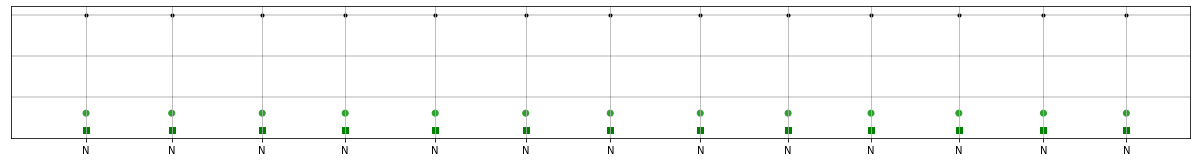

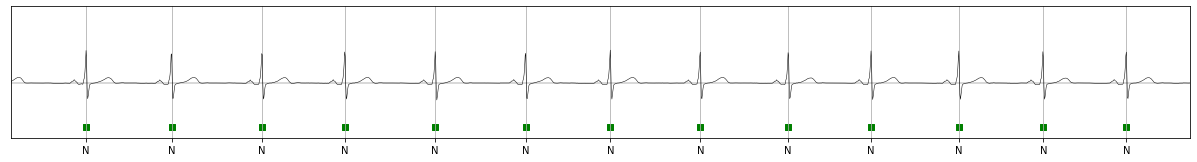

In [61]:
#<<--------------------------------------------------------------------
x_scale = 25 * 0.0393701 # mm/sec -> inches/sec
y_scale = 10 * 0.0393701 # mm/mV -> inches/sec
y_low = -2.5
y_high = 3.5
#------------------------------------------------------------

ff=45
tt=ff+17
sgv,_,_=plot_ecg_segment(sbi, sel_signal, 
                 ff, tt, 
                 x_scale, y_scale, y_low, y_high,
                 -2, False, predx, data_y, 'tab:blue', gain=1)




---

EOE

---

